# Word Segmentation and Association

![](../figs/intro_nlp/words/entelecheia_associaltion_vs_segmentation.png)

## Word Segmentation

- **Word segmentation** is the task of splitting a string of characters into words.
- Word segmentation is important for a machine to understand the meaning of a sentence.
- In English, we can split a string of characters into words by spaces.
- However, in languages like Chinese and Janpanese, there is no space between words.  
- Even in English, there are some cases where no space is used between words.
- Humans can easily segment a string of characters into words, even though there is no space between words.
- For example, we can easily segment the string of characters `Ilikechocolate` into words `I like chocolate`.

## Why should we segment words?

There are many applications that require word segmentation, even in English.

- Normalizing English compound nouns that are variably written for search engines.
  - For example, `ice cream` and `ice-cream` should be segmented into `icecream`.
- Word segmentation for compounds: Both orginal words and split words should be in the dictionary.
- Typing errors may be corrected by word segmentation.
- Conversion errors: During conversion, some spaces may be lost.
- OCR errors: OCRed text may contain errors.
- Keyword extraction from URL addresses, domain names, table column description or programming variables that are written without spaces.
- For password analysis, the extraction of terms from passwords can be required.
- Automatic CamelCasing of programming variables.
- Speech recognition: Speech recognition systems may not properly recognize spaces between words.


## Generating segment variants

We can generate all possible segment variants of a string of characters. Each distinct segment variant is called a **composition**.

- En a string of length $n$, there are $n-1$ possible positions to split the string.
- Each of the $n-1$ positions can be used as word boundary.
- Therefore, there are $2^{n-1}$ possible compositions.

The compositions have to be evaluated to find the best segmentation.

- The best segmentation is the one that has the highest probability.


### Naive Recursive Algorithm

- The naive recursive algorithm is to generate all possible compositions and evaluate them.
- The time complexity of the naive recursive algorithm is $O(2^n)$.
- The naive recursive algorithm is not efficient for long strings.

In [1]:
from pprint import pprint

def segment_naive(string):
    if not string:
        return []
    else:
        return [[string]] + [
            [string[:i]] + rest
            for i in range(1, len(string))
            for rest in segment_naive(string[i:])
        ]

In [2]:
pprint(segment_naive("isit"))

[['isit'],
 ['i', 'sit'],
 ['i', 's', 'it'],
 ['i', 's', 'i', 't'],
 ['i', 'si', 't'],
 ['is', 'it'],
 ['is', 'i', 't'],
 ['isi', 't']]


In [3]:
pprint(segment_naive("가방에"))

[['가방에'], ['가', '방에'], ['가', '방', '에'], ['가방', '에']]


In [4]:
text = "thisislongtext"
print(len(text), len(segment_naive(text)))

14 8192


In [5]:
text = "아버지가방에들어가신다" # Father goes into the bag or Father enters the room
print(len(text), len(segment_naive(text)))

11 1024


### Dynamic Programming

- Dynamic programming is a technique to solve a problem by breaking it into subproblems and storing the results of subproblems to avoid computing the same results again.
- The time complexity of dynamic programming is $O(n)$.
- For long strings, dynamic programming is much more efficient than the naive recursive algorithm.

```python
def segment(string, dictionary):
    if not string:
        return []
    for end in range(1, len(string) + 1):
        first, rest = string[:end], string[end:]
        if first in dictionary:
            return [first] + segment(rest, dictionary)
    return [string]
```

### Triangular Matrix

- The dynamic programming algorithm can be implemented using a triangular matrix.
- The tryangular matrix algorithm uses nested loops and a circular buffer to store the results of subproblems.
- A triangular matrix of parts with increasing length is generated and organized in a circular buffer.
- This allows a constant amount of memory to be used for the algorithm.


### Maximum Matching Algorithm

- If we have all known words in a dictionary, we can use the maximum matching algorithm to segment a sentence.
- The maximum matching algorithm is a greedy algorithm that finds the longest matching word from the dictionary.
- The algorithm is as follows:

    1. Find the longest matching word from the dictionary.
    2. If the word is found, add the word to the result and remove the word from the input.
    3. If the word is not found, add the first character to the result and remove the first character from the input.
    4. Repeat 1-3 until the input is empty.

### Unknown Words

- We can not rely on the dictionary to segment all words.
- There are uncommon words, new words, misspelled words, foreign words, proper nouns, slang words, etc.
- Even in these cases, we want to segment the words into meaningful parts.
- Therefore, we have to estimate the probability of any possible segmentation.

## Evaluation of Compositions

- Generally, we can evaluate a composition by calculating the probability of the composition.
- Word probabilities can be estimated from a corpus:

    $$
    P(w_i) = \frac{c(w_i)}{N}
    $$

    where $c(w_i)$ is the count of word $w_i$ and $N$ is the total number of words in the corpus.

- However, for unkonwn words, we have to use other criteria to evaluate the composition.
- At word boundary, the uncertainty of the segmentation increases.
- By measuring the uncertainty, we can evaluate the composition.

## Uncertainty of word boundaries

- The uncertainty of word boundaries can be measured by the entropy of the word boundary.
- {cite}`harris1970phoneme` said that if the uncertainty of successive tokens increases, the location is a word boundary.
- {cite}`feng2004accessor` proposed a statistical criterion called accessor variety (AV) to measure how likely a sub-sequence is a word, and then to find the best segmentation pattern that maximizes a target function of accessor variety and the length of the sub-sequence as variants. 
- {cite}`jin2006unsupervised` proposed branching entropy as another criterion for unsupervised segmentation.
- Both criteria share a similar assumption as in the fundamental work by Harris, 1970, that the uncertainty of successive tokens increases at word boundaries.
- The latter is the countinous version of the former.


![](../figs/intro_nlp/words/branching_entropy_uncertainty.png)


### Accessor Variety

- The accessor variety (AV) defines that the uncertainty of a sub-sequence is the number of different words that can be formed by adding a sub-sequence to the sub-sequence.
- For the forward accessor variety, it is the number of different words that can be formed by adding a sub-sequence to the right side of the sub-sequence.
- For the following sub-sequence, the forward accessor variety of `hope` is 2, because `hope` can be followed by `less` or `fully`.

    ```
    "hopeful": 100
    "hopeless": 80
    ```

- The backward accessor variety is the number of different words that can be formed by adding a sub-sequence to the left side of the sub-sequence.
- For example, the backward accessor variety of `less` is 3, because `hopeless`, `useless`, and `pointless` can be formed by adding `less` to the left side of `less`.

    ```
    "hopeless": 80
    "unless": 160
    "pointless": 70
    ```
- Depending on the language, the forward accessor variety or the backward accessor variety may be more suitable for segmentation.
- Threshold values can be used to determine the word boundaries.
- The threshold values can be determined by the corpus.

### Branching Entropy

**Assumption 1**: The uncertainty of successive tokens increases at word boundaries.

- Given a set of elements $X$ and a set of n-gram sequences $X_n$, the conditional entropy of an element occuring after an n-gram sequence $X_n$ is defined as:

    $$
    H(X|X_n) = -\sum_{x_n \in X_n} P(x_n) \sum_{x \in X} P(x|x_n) \log P(x|x_n)
    $$

    where $P(x) = P(X=x)$, $P(x|x_n) = P(X=x|X_n=x_n)$, and $P(X=x)$ indicates the probability of an element $x$ occuring in $X$.
- $H(X|X_n)$ decreases as $n$ increases, meaning that $X$ will become more predictable as $X_n$ becomes longer.
- The latter half of the equation, the entropy of $X$ given $X_n$, indicates the average information of branching out from a specific n-gram sequence $X_n$:

    $$
    H(X|X_n=x_n) = -\sum_{x \in X} P(x|x_n) \log P(x|x_n)
    $$

- This local entropy is the branching entropy of $X$ given $X_n$, and denoted as $h(x_n)$:

    $$
    h(x_n) = -\sum_{x \in X} P(x|x_n) \log P(x|x_n)
    $$


**Assumption 2**: If the entropy of successive tokens is high or increasing, the location is a word boundary.

- Generally, as the length of the n-gram sequence increases, the entropy of the n-gram sequence decreases.

    $$
    h(x_n) \geq h(x_{n-1})
    $$
    
- If $x_n$ is the prefix of $x_{n+1}$, the branching entropy of $x_n$ will likely be smaller than that of $x_{n+1}$:

    $$
    h(x_n) < h(x_{n+1})
    $$
    
- There are three boundary conditions to decide whether $x_n$ is a word boundary:

    1. $B_{max}$: If $h(x_n) > \text{val}_{max}$
    2. $B_{increase}$: $h(x_n) > h(x_{n-1})$
    3. $B_{ordinary}$: $h(x_n) > \text{val}_{ordinary}$

![](../figs/intro_nlp/words/branching_entropy.png)

## Word Segmentation in Practice

In [3]:
texts = [
    "like apples",
    "likes pineapples and apples",
    "dislikes Apple and pineapple",
    "People dislike pineapples.",
    "An apple makes people healthy.",
    "Pine trees make pineapple",
    "Pineapple unhealthy",
    "likeness of apples",
    "dislikeness of pineapples",
    "health of pineapple",
    "healthiness of apple",
    "display of pineapples",
    "unhealthy of apples",
    "unhealthiness of pineapples",
    "unlike apples",
    "kindness of apples",
    "kind of pineapples",
    "apple tree",
    "pineapple tree",
]

In [4]:
%config InlineBackend.figure_format='retina'
from ekorpkit.tokenizers.branching import BranchingEntropyTokenizer

bet = BranchingEntropyTokenizer()
bet.train_from_iterator(texts, min_frequency=1, verbose=True)

  0%|          | 0/19 [00:00<?, ?it/s]

Total words: 29
Top 10 words: [('▁of', 9), ('▁apples', 6), ('▁pineapples', 5), ('▁pineapple', 5), ('▁apple', 4), ('▁and', 2), ('▁people', 2), ('▁unhealthy', 2), ('▁tree', 2), ('▁like', 1)]
Total words after filtering: 29


  0%|          | 0/29 [00:00<?, ?it/s]

Total subwords: 543
Top 10 subwords: [('▁', 114), ('e', 63), ('p', 59), ('l', 37), ('a', 33), ('s', 30), ('i', 27), ('n', 26), ('pl', 24), ('ple', 23)]


Building forward trie:   0%|          | 0/543 [00:00<?, ?it/s]

Building backward trie:   0%|          | 0/543 [00:00<?, ?it/s]

In [5]:
sequence = texts[2]
print(bet._tokenizer.normalize(sequence))
print(bet._tokenizer.pre_tokenize(sequence))


dislikes apple and pineapple
['▁dislikes', '▁apple', '▁and', '▁pineapple']


In [4]:
word = "pineapples"
results = bet.find_local_entropy(word, direction="forward")
results


[('p', 0.5250355693505371, 0.0),
 ('i', 0.3496905752250248, -0.1753449941255123),
 ('n', 0.3496905752250248, 0.0),
 ('e', 0.44914649901267, 0.09945592378764523),
 ('a', 0.3499656090752427, -0.0991808899374273),
 ('p', 0.3499656090752427, 0.0),
 ('p', 0.3499656090752427, 0.0),
 ('l', 0.3499656090752427, 0.0),
 ('e', 0.6764449241372277, 0.32647931506198496),
 ('s', 0.5144984575880421, -0.16194646654918554)]

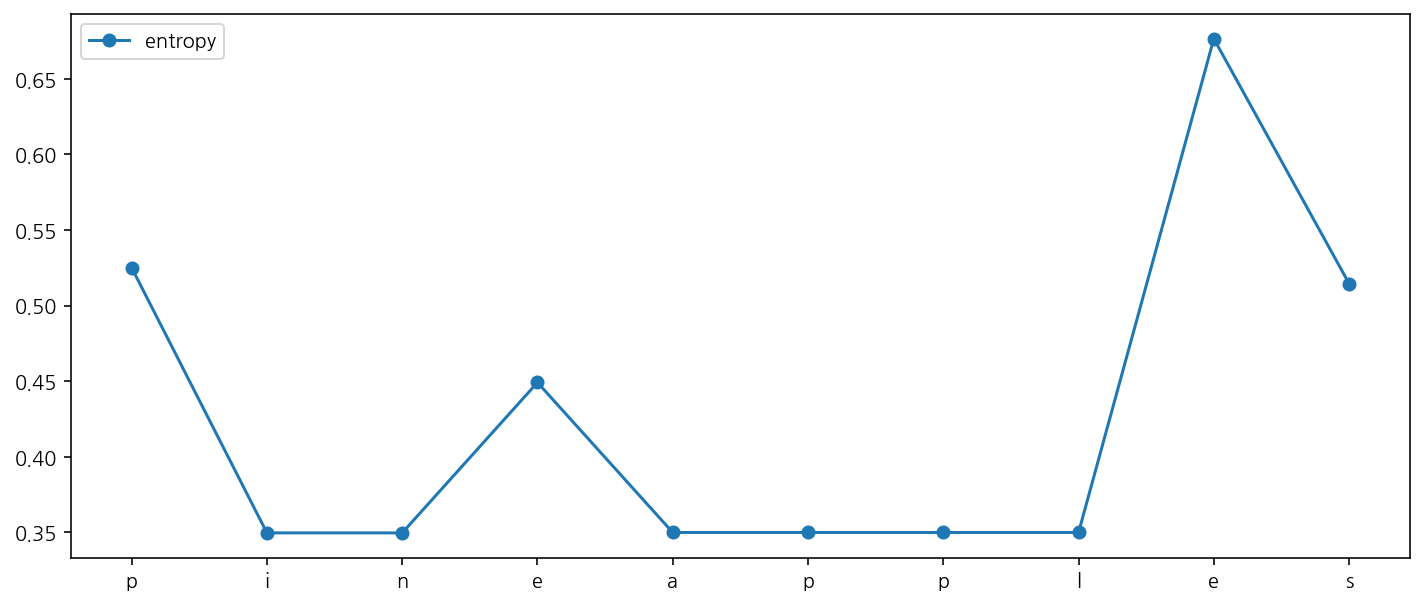

In [5]:
bet.plot_local_entropy(word, direction="forward")

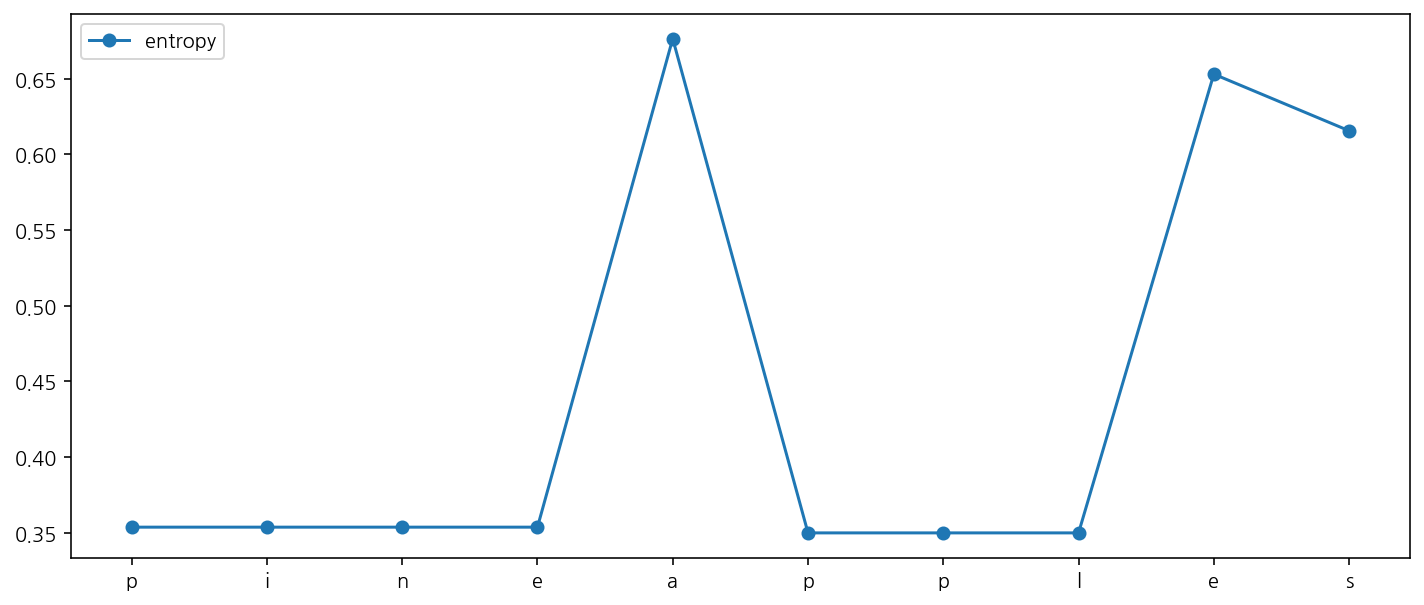

In [6]:
bet.plot_local_entropy(word, direction="backward")

In [7]:
tokenized = [bet.tokenize(text, flatten=False) for text in texts]
tokenized

[[('▁like',), ('▁apple', 's')],
 [('▁like', 's'), ('▁pineapple', 's'), ('▁and',), ('▁apple', 's')],
 [('▁dis', 'like', 's'), ('▁apple',), ('▁and',), ('▁pineapple',)],
 [('▁people',), ('▁dis', 'like'), ('▁pineapple', 's.')],
 [('▁an',), ('▁apple',), ('▁make', 's'), ('▁people',), ('▁health', 'y.')],
 [('▁pine',), ('▁tree', 's'), ('▁make',), ('▁pineapple',)],
 [('▁pineapple',), ('▁un', 'health', 'y')],
 [('▁like', 'ness'), ('▁of',), ('▁apple', 's')],
 [('▁dis', 'like', 'ness'), ('▁of',), ('▁pineapple', 's')],
 [('▁health',), ('▁of',), ('▁pineapple',)],
 [('▁health', 'iness'), ('▁of',), ('▁apple',)],
 [('▁dis', 'play'), ('▁of',), ('▁pineapple', 's')],
 [('▁un', 'health', 'y'), ('▁of',), ('▁apple', 's')],
 [('▁un', 'health', 'iness'), ('▁of',), ('▁pineapple', 's')],
 [('▁un', 'like'), ('▁apple', 's')],
 [('▁kind', 'ness'), ('▁of',), ('▁apple', 's')],
 [('▁kind',), ('▁of',), ('▁pineapple', 's')],
 [('▁apple',), ('▁tree',)],
 [('▁pineapple',), ('▁tree',)]]

In [7]:
tokenized = [bet.tokenize(text, direction="backward") for text in texts]
tokenized


[['▁like', '▁appl', 'es'],
 ['▁likes', '▁pine', 'appl', 'es', '▁a', 'nd', '▁appl', 'es'],
 ['▁dis', 'likes', '▁ap', 'ple', '▁a', 'nd', '▁pine', 'ap', 'ple'],
 ['▁people', '▁dis', 'like', '▁pineapples.'],
 ['▁an', '▁ap', 'ple', '▁makes', '▁people', '▁healthy.'],
 ['▁pine', '▁tre', 'es', '▁make', '▁pine', 'ap', 'ple'],
 ['▁pine', 'ap', 'ple', '▁unhealthy'],
 ['▁like', 'ness', '▁of', '▁appl', 'es'],
 ['▁dis', 'like', 'ness', '▁of', '▁pine', 'appl', 'es'],
 ['▁health', '▁of', '▁pine', 'ap', 'ple'],
 ['▁healthi', 'ness', '▁of', '▁ap', 'ple'],
 ['▁display', '▁of', '▁pine', 'appl', 'es'],
 ['▁unhealthy', '▁of', '▁appl', 'es'],
 ['▁un', 'healthi', 'ness', '▁of', '▁pine', 'appl', 'es'],
 ['▁un', 'like', '▁appl', 'es'],
 ['▁kind', 'ness', '▁of', '▁appl', 'es'],
 ['▁ki', 'nd', '▁of', '▁pine', 'appl', 'es'],
 ['▁ap', 'ple', '▁tree'],
 ['▁pine', 'ap', 'ple', '▁tree']]

In [8]:
bet.naive_segment("ilikeanapple")

['i', 'like', 'an', 'apple']

### Word Segmentation for Korean

In [8]:
texts = [
    "아버지가 방에 들어가신다",
    "아버지는 방에 들어가셨다",
    "가방을 들다",
    "방을 나가다",
    "가방을 들고 나갔다",
    "가방이 방에 있었다",
    "가방은 방안에 있다",
    "가방은 방에 있었다",
    "가방을 방으로 들고 들어갔다",
    "가방을 들고 집으로 갔다",
    "방은 집안에 있다",
    "집으로 가다",
]

In [9]:
from ekorpkit.tokenizers.branching import BranchingEntropyTokenizer

bet = BranchingEntropyTokenizer()
bet.train_from_iterator(texts, min_frequency=1, verbose=True)

  0%|          | 0/12 [00:00<?, ?it/s]

Total words: 23
Top 10 words: [('▁방에', 4), ('▁가방을', 4), ('▁들고', 3), ('▁있었다', 2), ('▁가방은', 2), ('▁있다', 2), ('▁집으로', 2), ('▁아버지가', 1), ('▁들어가신다', 1), ('▁아버지는', 1)]
Total words after filtering: 23


  0%|          | 0/23 [00:00<?, ?it/s]

Total subwords: 201
Top 10 subwords: [('▁', 70), ('방', 15), ('가', 12), ('다', 12), ('다▁', 12), ('▁방', 8), ('▁가', 8), ('▁들', 7), ('들', 7), ('▁가방', 7)]


Building forward trie:   0%|          | 0/201 [00:00<?, ?it/s]

Building backward trie:   0%|          | 0/201 [00:00<?, ?it/s]

In [10]:
tokenized = [bet.tokenize(text, branching_threshold=0.0) for text in texts]
tokenized

[['▁아버지', '가', '▁방에', '▁들어가신다'],
 ['▁아버지', '는', '▁방에', '▁들어가셨다'],
 ['▁가방', '을', '▁들다'],
 ['▁방을', '▁나가다'],
 ['▁가방', '을', '▁들고', '▁나갔다'],
 ['▁가방', '이', '▁방에', '▁있었다'],
 ['▁가방', '은', '▁방안에', '▁있다'],
 ['▁가방', '은', '▁방에', '▁있었다'],
 ['▁가방', '을', '▁방으로', '▁들고', '▁들어갔다'],
 ['▁가방', '을', '▁들고', '▁집으로', '▁갔다'],
 ['▁방은', '▁집안에', '▁있다'],
 ['▁집으로', '▁가다']]

In [11]:
tokenized = [
    bet.tokenize(text, direction="backward", branching_threshold=0.0) for text in texts
]
tokenized


[['▁아버지가', '▁방에', '▁들어가신다'],
 ['▁아버지는', '▁방에', '▁들어가셨다'],
 ['▁가', '방을', '▁들다'],
 ['▁방을', '▁나가다'],
 ['▁가', '방을', '▁들고', '▁나갔다'],
 ['▁가방이', '▁방에', '▁있었다'],
 ['▁가', '방은', '▁방안에', '▁있다'],
 ['▁가', '방은', '▁방에', '▁있었다'],
 ['▁가', '방을', '▁방', '으로', '▁들고', '▁들어갔다'],
 ['▁가', '방을', '▁들고', '▁집', '으로', '▁갔다'],
 ['▁방은', '▁집안에', '▁있다'],
 ['▁집', '으로', '▁가다']]

In [12]:
bet.naive_segment("아버지가방에들어가신다")

['아버지가', '방에', '들어가신다']

In [13]:
bet.naive_segment("아버지가가방을들고가신다")

['아버지가', '가방을', '들고', '가', '신다']

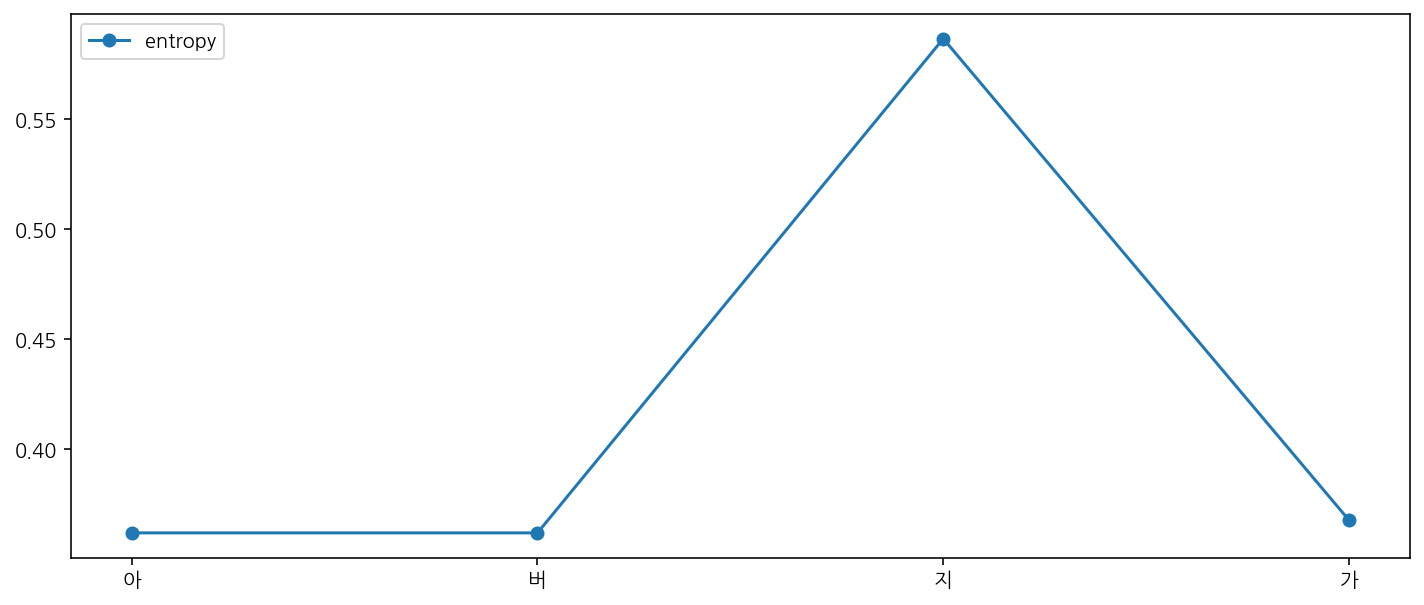

In [14]:
bet.plot_local_entropy(word="아버지가", direction="forward")

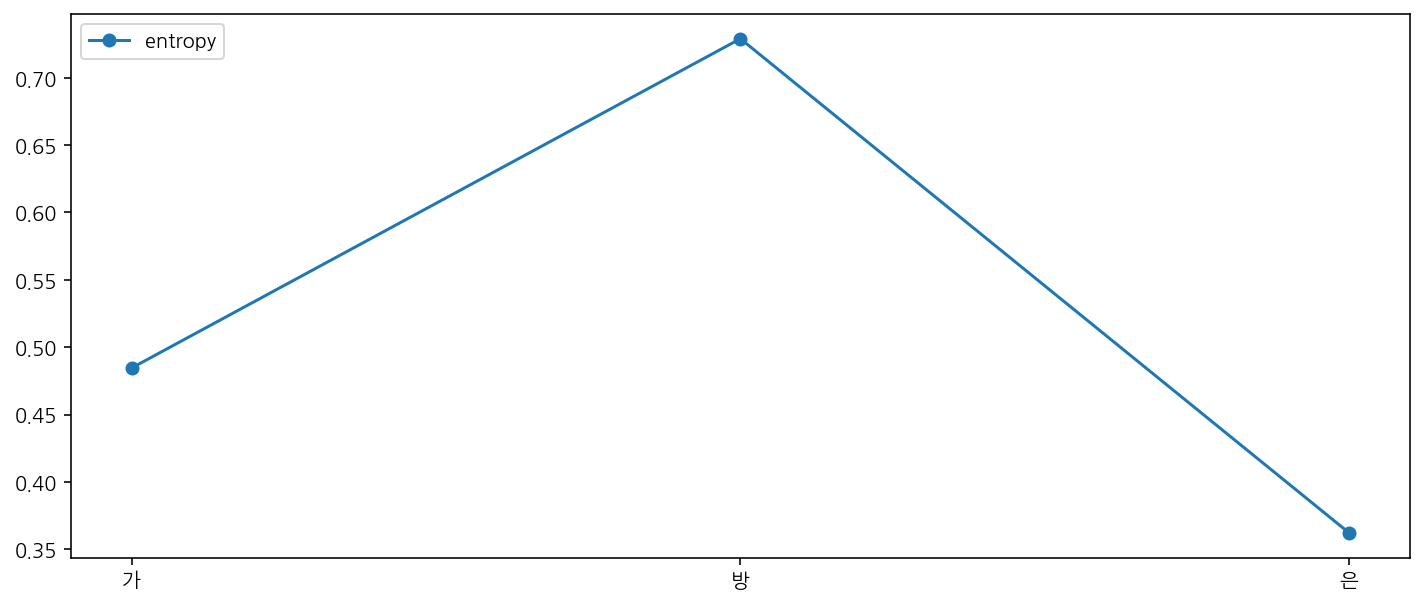

In [15]:
bet.plot_local_entropy(word="가방은", direction="forward")

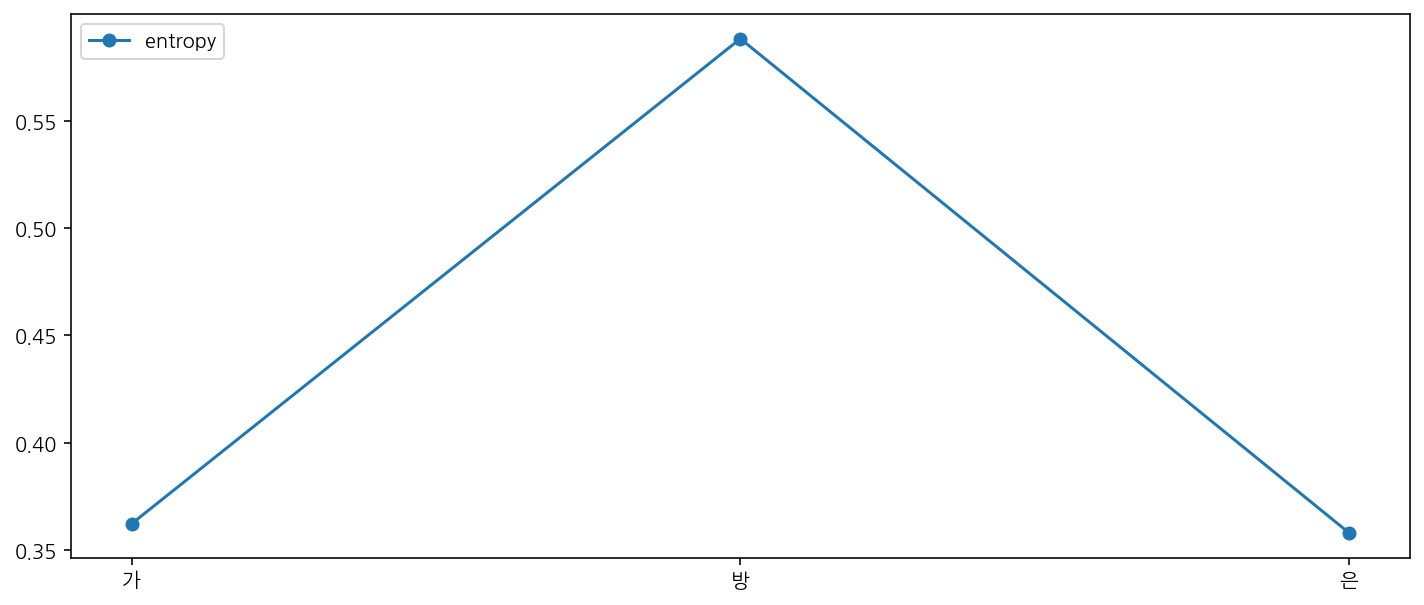

In [12]:
bet.plot_local_entropy(word="가방은", direction="backward")

### Working with news article samples

In [10]:
from ekorpkit import eKonf

cfg = eKonf.compose("path")
cfg.cache.uri = "https://github.com/entelecheia/ekorpkit-book/raw/main/assets/data/us_equities_news_sampled.zip"
data = eKonf.load_data("us_equities_news_sampled.parquet", cfg.cached_path)
texts = data.text

In [11]:
from ekorpkit.tokenizers.branching import BranchingEntropyTokenizer

bet = BranchingEntropyTokenizer()
bet.train_from_iterator(texts, min_frequency=1, verbose=True)

  0%|          | 0/22098 [00:00<?, ?it/s]

Total words: 107685
Top 10 words: [('▁the', 715895), ('▁to', 334075), ('▁of', 314837), ('▁in', 278030), ('▁and', 274910), ('▁a', 259527), ('▁s', 169595), ('▁for', 133255), ('▁is', 130552), ('▁on', 113286)]
Total words after filtering: 107685


  0%|          | 0/107685 [00:00<?, ?it/s]

Total subwords: 3019773
Top 10 subwords: [('▁', 26177132), ('e', 7246161), ('t', 5334633), ('a', 4971213), ('o', 4428694), ('n', 4415394), ('i', 4397713), ('s', 4366700), ('r', 4125315), ('l', 2404918)]


Building forward trie:   0%|          | 0/3019773 [00:00<?, ?it/s]

Building backward trie:   0%|          | 0/3019773 [00:00<?, ?it/s]

In [12]:
bet.save("../data/tokenizers/", "branching")

['../data/tokenizers/branching/vocab.json',
 '../data/tokenizers/branching/config.json']

In [13]:
from ekorpkit.tokenizers.branching import BranchingEntropyTokenizer

bet = BranchingEntropyTokenizer.load("../data/tokenizers/", "branching", branching_threshold=0.2)

Building forward trie:   0%|          | 0/3019773 [00:00<?, ?it/s]

Building backward trie:   0%|          | 0/3019773 [00:00<?, ?it/s]

In [14]:
sequence = "Investment opportunities in the company."
print(bet.tokenize(sequence, flatten=False, direction="forward"))
print(bet.tokenize(sequence, flatten=False, direction="backward"))

[('▁invest', 'ment'), ('▁oppo', 'rtunit', 'ies'), ('▁in',), ('▁the',), ('▁company.',)]
[('▁invest', 'ment'), ('▁opportun', 'ities'), ('▁in',), ('▁the',), ('▁company.',)]


In [26]:
# print(bet.tokenize(texts[3], flatten=False, direction="forward", branching_threshold=0.3))

In [18]:
word = "investments"
print(bet.tokenize(word, flatten=False, direction="forward"))
results = bet.find_local_entropy(word, direction="forward")
results


[('▁invest', 'ments')]


[('i', 1.0095287438501144, 0.0),
 ('n', 1.1515486269045268, 0.14201988305441238),
 ('v', 0.45972611324043794, -0.6918225136640888),
 ('e', 0.4509164703468697, -0.008809642893568226),
 ('s', 0.35903206546025535, -0.09188440488661437),
 ('t', 0.9522316236050686, 0.5931995581448133),
 ('m', 0.3465757022785438, -0.6056559213265249),
 ('e', 0.3465757022785438, 0.0),
 ('n', 0.3465757022785438, 0.0),
 ('t', 0.6160316441204637, 0.26945594184191995),
 ('s', 0.3519227033342969, -0.2641089407861668)]

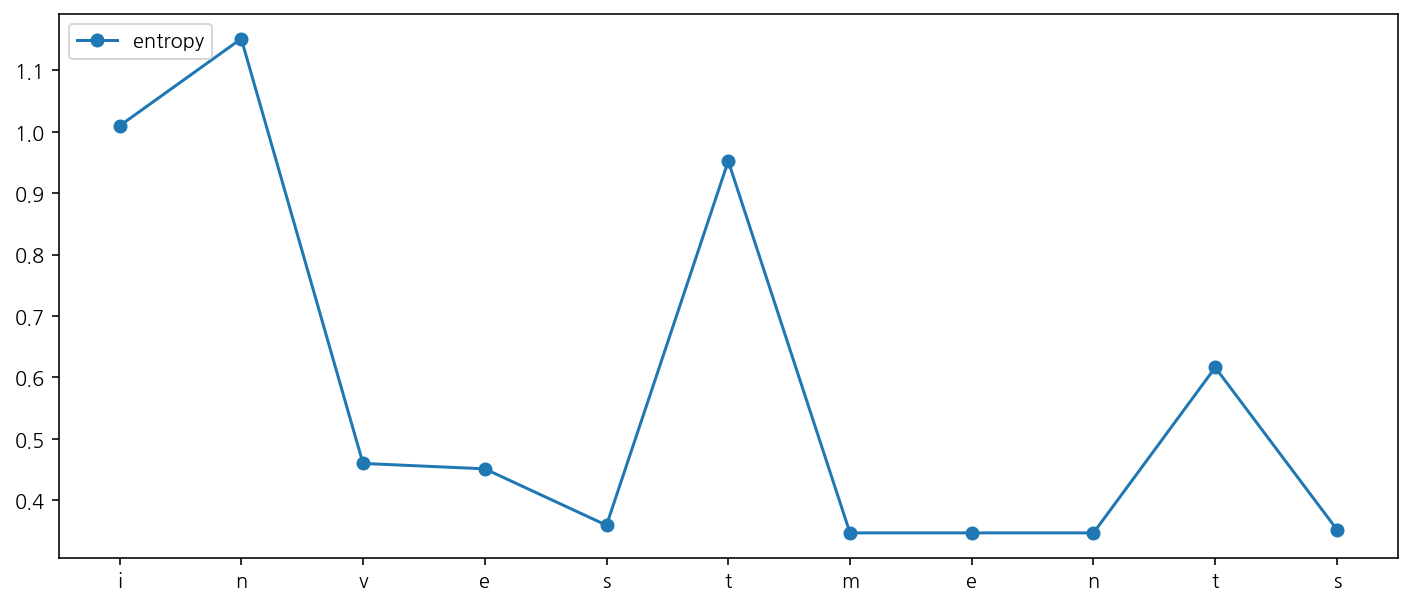

In [19]:
bet.plot_local_entropy(word, direction="forward")

In [20]:
word = "investments"
print(bet.tokenize(word, flatten=False, direction="backward"))
results = bet.find_local_entropy(word, direction="backward")
results


[('▁invest', 'ments')]


[('i', 0.3561165131571915, -0.009533638447234705),
 ('n', 0.3465828747099568, 0.026795502159956852),
 ('v', 0.37337837686991365, -0.026795591191855372),
 ('e', 0.3465827856780583, 0.13506944700263662),
 ('s', 0.4816522326806949, 0.21807907607263988),
 ('t', 0.6997313087533348, 0.624865765838529),
 ('m', 1.3245970745918638, -0.1795732287232441),
 ('e', 1.1450238458686197, -0.3379381071100026),
 ('n', 0.8070857387586171, 0.5204781480063937),
 ('t', 1.3275638867650108, 0.3191691594567949),
 ('s', 1.6467330462218057, 0.0)]

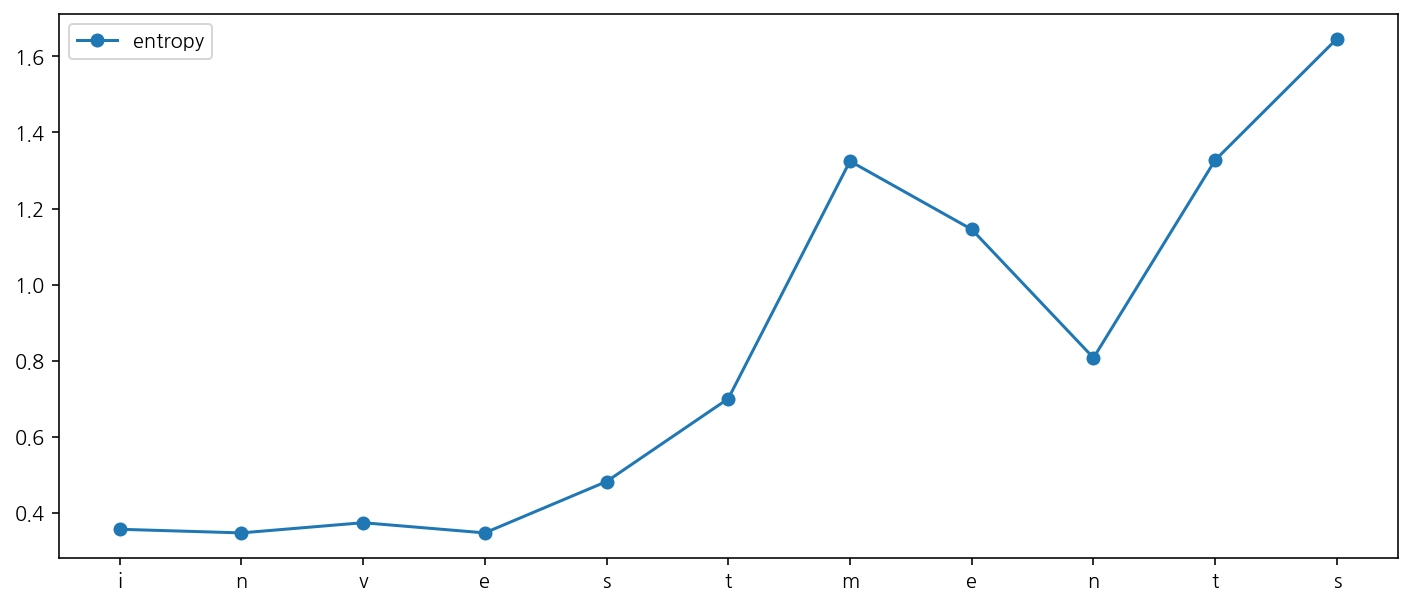

In [21]:
bet.plot_local_entropy(word, direction="backward")

## References

- [Uncertanty to word boundary; Accessor Variety & Branching Entropy](https://lovit.github.io/nlp/2018/04/09/branching_entropy_accessor_variety/)
- [Fast Word Segmentation of Noisy Text](https://medium.com/towards-data-science/fast-word-segmentation-for-noisy-text-2c2c41f9e8da)